# Setting everything up

In [399]:
import numpy as np
from numpy.random import default_rng
from scipy.special import eval_legendre
from scipy.linalg import svd, norm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

In [2]:
# just generates Gaussian data scaled to [-1,1]
def generate_scaled_data(N, d, seed=42):
    np.random.seed(seed)
    
    # Step 1: Sample from multivariate normal
    Z = np.random.randn(N, d)  # standard normal
    
    # Step 2: Scale each coordinate to [-1, 1]
    Z_min = Z.min(axis=0)
    Z_max = Z.max(axis=0)
    Z_scaled = 2 * (Z - Z_min) / (Z_max - Z_min) - 1  # linear transform to [-1, 1]
    
    return Z_scaled

In [3]:
def generate_gaussian(N, mean, std, seed=None):
    """
    Generate N points from a Gaussian with specified means and std deviations
    Eliminates points outside of [-1,1] to ensure the Legendre basis works well
    
    Returns:
        array of shape (N,) with Gaussian distribution
    """
    if seed is not None:
        np.random.seed(seed)
        
    vals = []
    while len(vals) < N:
        x = np.random.normal(loc=mean, scale=std, size=N)
        mask = (x >= -1) & (x <= 1)
        vals.extend(x[mask])
        
    return np.array(vals[:N])

In [386]:
def d_dim_gaussian_density(means, stds, grid_size=100, i=0, j=1):
    """
    Generates the density of a d-dimensional axis-aligned Gaussian,
    and returns a 2D slice over dimensions i and j for visualization.

    Args:
        means (list): List of length d of means.
        stds (list): List of length d of std deviations.
        grid_size (int): Resolution of the grid.
        i (int): Index of the first coordinate to slice.
        j (int): Index of the second coordinate to slice.

    Returns:
        X, Y: Meshgrid arrays for the i and j coordinates.
        density_slice: 2D array of shape (grid_size, grid_size) with the sliced density.
    """
    d = len(means)
    assert len(stds) == d
    assert 0 <= i < d and 0 <= j < d and i != j

    # Grid over [-1, 1]^d
    x = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, x)

    # Create meshgrid for all d dimensions, filled with zeros
    all_coords = np.zeros((grid_size, grid_size, d))

    # Set the i-th and j-th coordinates to vary over the grid
    all_coords[:, :, i] = X
    all_coords[:, :, j] = Y

    # Compute the density
    density = np.ones((grid_size, grid_size))
    for k in range(d):
        mu = means[k]
        sigma = stds[k]
        xk = all_coords[:, :, k]
        density *= (1.0 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((xk - mu) / sigma) ** 2)

    return X, Y, density

# Algorithm 1

In [4]:
def legendre_vals_1d(z, degree):
    """
    Evaluate the first (degree+1) normalized Legendre polynomials at points z ∈ [−1,1].
    Returns an (N, degree+1) array (note these are "features").
    """
    N = z.shape[0]
    P = np.empty((N, degree+1))
    # normalization sqrt((2k+1)/2) makes the polynomials orthonormal on [-1,1]
    for k in range(degree+1):
        Pk = eval_legendre(k, z)
        P[:, k] = np.sqrt((2*k+1)/2) * Pk
    return P

In [5]:
def build_Sj(features, j):
    """
    Given a list `features` of length d, where features[k] is (N, m_k),
    build the tensor-product feature matrix S_j for coordinate j:
    shape (N, ∏_{k≠j} m_k).
    """
    N = features[0].shape[0]
    # Start with a (N,1) column of ones
    S = np.ones((N, 1))
    for k, Fk in enumerate(features):
        if k == j:
            continue
        # S: (N, a), Fk: (N, b)
        # We want (N, a*b) where each (i, (p,q)) = S[i,p] * Fk[i,q]
        S = (S[:, :, None] * Fk[:, None, :]).reshape(N, -1)
    return S

In [6]:
def algorithm_1(data, r, m_list):
    """
    Generalized Algorithm 1 sketch for d-dimensional data.
    
    Inputs:
      - data:   array of shape (N, d) with each coord in [-1,1]
      - r:      target rank (must be <= min(m_j, ∏_{k≠j} m_k) for all j)
      - m_list: list of ints [m_0, m_1, ..., m_{d-1}], # of Legendre modes per coord
    
    Returns:
      - U_list: list of length d; U_list[j] is (m_j, r) matrix of top-left singular vecs
      - S_list: list of length d; S_list[j] is (r,) vector of singular values
      - V_list: list of length d; V_list[j] is (∏_{k≠j}m_k, r) matrix of top-right singular vecs
    """
    N, d = data.shape

    # Guarantees that whether we pass an r list or just r as an int it'll work
    if isinstance(r, int):
        r_list = [r]*d
    else:
        r_list = r
        
    # 1) Evaluate per-coordinate Legendre features
    features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(d)]
    
    U_list, S_list, V_list = [], [], []
    
    # 2) For each coordinate j, build sketch matrix C_j and SVD
    for j in range(d):
        Vj = features[j]               # (N, m_j)
        Sj = build_Sj(features, j)     # (N, L_j = ∏_{k≠j} m_k)
        
        if r_list[j] > min(Vj.shape[1], Sj.shape[1]):
            raise ValueError(f"r={r} too large for coordinate {j}: "
                             f"max rank = {min(Vj.shape[1], Sj.shape[1])}")
        
        # sketch moments: C_j[mu,eta] = (1/N) ∑_i Vj[i,mu] * Sj[i,eta]
        Cj = (Vj.T @ Sj) / N          # shape (m_j, L_j)
        
        # truncated SVD
        U, s, Vt = svd(Cj, full_matrices=False)
        U_list.append(U[:, :r_list[j]])       # (m_j, r)
        S_list.append(s[:r_list[j]])          # (r,)
        V_list.append(Vt[:r_list[j], :].T)    # (L_j, r)
    
    return U_list, S_list, V_list

## Sanity checks

In [7]:
N = 5000
x = np.random.uniform(-1,1, size=N)
y = np.random.uniform(-1,1, size=N)
data = np.vstack([x,y]).T       # shape (N,2)

# Run Algorithm 1 sketch with target rank r=2, using m=5 modes per coord
U_list, S_list, V_list = algorithm_1(data, r=3, m_list=[5,5])

# Inspect singular values for each coordinate
for j, s in enumerate(S_list):
    print(f"Coordinate {j}: singular values = {s}")

Coordinate 0: singular values = [0.50041926 0.02577929 0.02280971]
Coordinate 1: singular values = [0.50041926 0.02577929 0.02280971]


In [8]:
N = 10000
x = generate_gaussian(N, 0.2, .1, seed=0)
y = generate_gaussian(N, -0.1, 1, seed=1)
data = np.vstack([x, y]).T

# Run sketch
r = 3
m_list = [5, 5]
U_list, S_list, V_list = algorithm_1(data, r, m_list)

# Compute metrics
drop_ratios = []
alignments = []
for j in range(2):
    s = S_list[j]
    ratio = s[0] / (s[1] if len(s) > 1 and s[1] > 0 else np.nan)
    drop_ratios.append(ratio)
    # alignment with e0
    alignment = abs(U_list[j][0, 0])
    alignments.append(alignment)

results = pd.DataFrame({
    "Coordinate": [0, 1],
    "Singular Value": [S_list[0][0], S_list[1][0]],
    "Drop Ratio (1st/2nd)": drop_ratios,
    "Alignment with v₀": alignments
})

In [9]:
# the second coordinate should be much better aligned with v0 because v0 is a straight line (0th Legendre polynomial)
# and the second coordinate is a much wider Gaussian (closer to being a straight line)

results

,Coordinate,Singular Value,Drop Ratio (1st/2nd),Alignment with v₀
0,0,0.862566,108.707399,0.586598
1,1,0.862566,108.707399,0.988235


In [10]:
# 2) Check reconstruction error of C ≈ U S V^T
# Reconstruct C for j=0 (example)
features = [legendre_vals_1d(data[:, j], m_list[j]-1) for j in range(2)]
V0 = features[0]
S0 = build_Sj(features, 0)
C0 = (V0.T @ S0) / N
U0, s0, Vt0 = svd(C0, full_matrices=False)
# approximate C0
approxC0 = U0[:, :r] @ np.diag(s0[:r]) @ Vt0[:r, :]
recon_error = norm(C0 - approxC0, 'fro') / norm(C0, 'fro')

# 3) Stability under subsampling: split data
data_A = data[:N//2]
data_B = data[N//2:]
U_A, S_A, V_A = algorithm_1(data_A, r, m_list)
U_B, S_B, V_B = algorithm_1(data_B, r, m_list)

# Compute principal angle between U_A[j] and U_B[j] for each j
stability = []
for j in range(2):
    # since r=1, principal angle cos = |u_A^T u_B|
    cos_angle = abs((U_A[j][:, 0].T @ U_B[j][:, 0]))
    stability.append(cos_angle)

# 4) Compile results
results = pd.DataFrame({
    "Check": ["Reconstruction Error", "Stability Coord 0", "Stability Coord 1"],
    "Value": [recon_error, stability[0], stability[1]]
})

results

,Check,Value
0,Reconstruction Error,0.000106
1,Stability Coord 0,0.999998
2,Stability Coord 1,0.999875


# Algorithm 3

In [57]:
def ttm(tensor, matrix, mode):
    """
    Mode-n product of `matrix` (shape (J, I_mode))
    with `tensor` (shape (..., I_mode, ...))
    same as tensorly.tenalg.mode_dot(tensor, matrix, mode).
    """
    # 1) tensordot over tensor's axis=mode and matrix's axis=1
    #    result shape = (J, ...) where ... are tensor.shape without mode
    res = np.tensordot(matrix, tensor, axes=[1, mode])
    # 2) we need to move the new axis-0 (the J dimension) into position `mode`
    #    so construct the new axis order
    ndim = tensor.ndim
    # current res axes:    [ new_axis ] + [ all old axes except `mode`, in order ]
    # we want new_axis to go to position `mode`, and shift axes <mode> left by 1
    axes = list(range(1, mode+1)) + [0] + list(range(mode+1, ndim))
    return np.transpose(res, axes)

In [58]:
def compute_coeff_tensor(features):
    """
    Given features = [F0,...,F{d-1}], each Fk is (N, m_k),
    return coefficient tensor C of shape (m0,...,m{d-1}) via einsum:
      C[μ0,μ1,...,μ{d-1}] = (1/N)*sum_i F0[i,μ0]*F1[i,μ1]*...*F{d-1}[i,μ{d-1}]
    Note this function will fail for d>25, just need to add more letters
    """
    # build the subscripts for einstein summation
    d = len(features)
    
    # indices: i for sample dimension, a,b,c,... for feature dims
    letters = 'abcdefghijklmnopqrstuvwxyz'
    sample_idx = letters[0]
    feat_idxs = letters[1:d+1]

    # e.g. "ab,ac,ad->bcd" for d=3
    einsum_str = ','.join(f'{sample_idx}{f}' for f in feat_idxs)
    einsum_str += '->' + ''.join(feat_idxs)
    
    C = np.einsum(einsum_str, *features) / features[0].shape[0]
    
    return C

In [59]:
def algorithm_3(data, r_list, m_list):
    """
    Algorithm 3 in terms of repeated calls to Algorithm 1.
    Returns final coefficient tensor C_e and list of basis functions.
    """
    N, d = data.shape
    assert N % 2 == 0, "N must be even for two passes"
    half = N // 2

    # split data in half
    A_h, A_hp = data[:half], data[half:]

    # 1) First pass: initial subspace estimation via Algorithm 1
    U_list,_,_ = algorithm_1(A_h, r_list, m_list)
    P_U = [U @ U.T for U in U_list]    # projectors P_{U_j}

    # 2) Build per-half feature lists
    feats_h  = [legendre_vals_1d(A_h[:, j],  m_list[j]-1) for j in range(d)]
    feats_hp = [legendre_vals_1d(A_hp[:,j],  m_list[j]-1) for j in range(d)]

    # 3) Compute coefficient tensor from first half
    C_h = compute_coeff_tensor(feats_h)  # shape = tuple(m_list)

    # 4) Second pass: refine projectors P_{V_j}
    V_list = []
    for j in range(d):
        # partially project C_h along all modes except j
        B_j = C_h.copy()
        for k in range(d):
            if k == j: 
                continue
            B_j = ttm(B_j, P_U[k], mode=k)

        # unfold into a matrix for SVD
        shape = B_j.shape
        m_j   = shape[j]
        other = int(np.prod([shape[k] for k in range(d) if k != j]))
        # move mode j to front, then reshape
        B_mat = np.moveaxis(B_j, j, 0).reshape(m_j, other)

        # SVD and take top r_j left singular vectors
        U, _, _ = svd(B_mat, full_matrices=False)
        Vj = U[:, :r_list[j]]   # (m_j, r_j)
        V_list.append(Vj)

    P_V = [V @ V.T for V in V_list]  # refined projectors

    # 5) Final sketch on second half
    C_hp = compute_coeff_tensor(feats_hp)
    C_e  = C_hp.copy()
    for j in range(d):
        C_e = ttm(C_e, P_V[j], mode=j)

    # 6) Basis evaluators (for reconstruction)
    basis = [lambda z, deg=m_list[j]-1: legendre_vals_1d(z, deg)
             for j in range(d)]

    return C_e, basis

In [71]:
# evaluate density at a test point
def eval_density(C, basis, z):
    """
    Evaluate the estimated density at point z = (z0, ..., z_{d-1}).
    """
    # 1) build the list of basis‐vector for each coord: shape (m_j,)
    vecs = [basis[j](np.array([z[j]]))[0] for j in range(len(z))]
    # 2) build an einsum string, e.g. for d=3: "ijk,i,j,k->"
    d = len(z)
    letters = ''.join(chr(ord('a')+j) for j in range(d))     # 'abc' for d=3
    einsum_str = f"{letters}," + ",".join(letters) + "->"
    # 3) einsum over all modes
    return np.einsum(einsum_str, C, *vecs)

## Sanity check

In [180]:
# toy data
d = 4
N = 10000
data = np.random.uniform(-1,1,(N,d))
r_list = [3]*d
m_list = [5]*d

C_e, basis = algorithm_3(data, r_list, m_list)

# shouldn't matter at what point we look (uniform density)
z_test = (0.1, -0.5, 0.8, .4)

# would expect to be approx 1/2^d because this the volume, uniform density
print("Estimated density at", z_test, "=", eval_density(C_e, basis, z_test))
print("Expected density: ", 1/2**d)

Estimated density at (0.1, -0.5, 0.8, 0.4) = 0.06671737736184018
Expected density:  0.0625


In [830]:
# clearly this is the bottleneck, e.g. run for d = 7 and see how slow it is

m = 8
d = 5
N = 10000

compute_coeff_tensor([legendre_vals_1d(np.random.uniform(-1,1,N),m) for i in range(d)]).shape

(9, 9, 9, 9, 9)

# Trying to recreate results

## First a 2D Gaussian

In [391]:
data = np.vstack([generate_gaussian(1000,0.3,0.1),generate_gaussian(1000,-0.4,0.3)]).T

grid_size = 100

x = y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

In [392]:
r_list = [3, 3]      # basis size per dimension
m_list = [16, 16]      # number of projections per dimension

# Run algorithm 3
C_e, basis = algorithm_3(data, r_list, m_list)

In [393]:
density_vrs = np.array([eval_density(C_e, basis, z) for z in grid_points])
density_vrs = density_vrs.reshape(grid_size, grid_size)

In [394]:
kde = gaussian_kde(data.T)
density_kde = kde(grid_points.T).reshape(grid_size, grid_size)

In [824]:
_, _, true_density = d_dim_gaussian_density([0.3, -0.4], [0.1, 0.3])

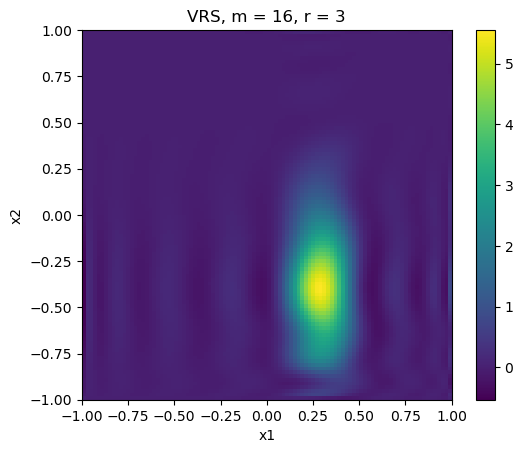

In [396]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 16, r = 3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

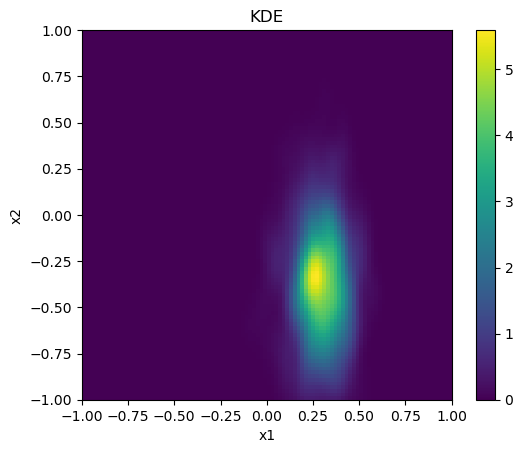

In [397]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

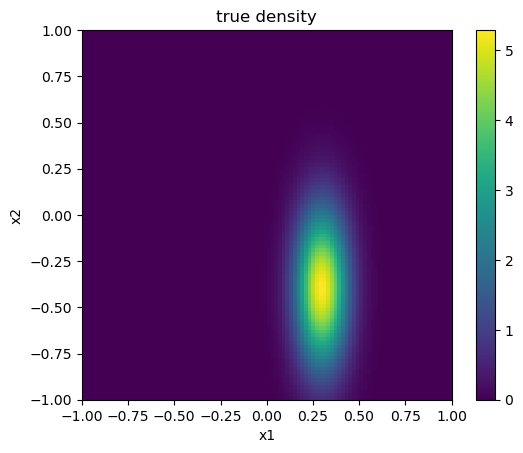

In [825]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true density')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()

In [270]:
dx = x[1] - x[0]
dy = y[1] - y[0]

tot_density_vrs = density_vrs.sum() * dx * dy
tot_density_kde = density_kde.sum() * dx * dy

print("Total VRS density: ", tot_density_vrs)
print("Total KDE density: ", tot_density_kde)

Total VRS density:  1.0080822787568593
Total KDE density:  0.9906467064997537


## d-dimensional Gaussian

In [810]:
d = 4

mean = 0.5
std = 0.1
data = np.vstack([generate_gaussian(1000, mean, std) for i in range(d)]).T

In [811]:
# Getting the densities using VRS
r_list = [10]*d    # basis size per dimension
m_list = [50]*d      # number of projections?

# Run algorithm 3
C_e, basis = algorithm_3(data, r_list, m_list)

In [812]:
# Getting the densities using KDE
kde = gaussian_kde(data.T)

In [813]:
# two coordinates we want to visualize
slice1, slice2 = 2, 3

fixed_val = 0.0
grid_size = 100

In [814]:
# prepare 2D grid for axes (slice1, slice2)
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
grid_points_sliced = np.vstack([X.ravel(), Y.ravel()]).T   # (grid_size**2, 2)

# Embed into d-dimensions by fixing all other coords
full_points = np.full((grid_size*grid_size, d), fixed_val)
full_points[:, slice1] = grid_points_sliced[:, 0]
full_points[:, slice2] = grid_points_sliced[:, 1]

In [815]:
# evaluating VRS on these points

density_vrs = np.array([
    eval_density(C_e, basis, z) 
    for z in full_points
])
density_vrs = density_vrs.reshape(grid_size, grid_size)

# Set any negative values to 0, ad hoc, should fix
density_vrs[density_vrs < 0] = 0

In [816]:
# evaluating kde on these points

kde = gaussian_kde(data.T)
density_kde = kde(full_points.T).reshape(grid_size, grid_size)

In [817]:
# getting the true density

_, _, true_density = d_dim_gaussian_density([mean]*d,[std]*d, grid_size = grid_size, i = 2, j = 3)

In [ ]:
# these figures below have mean -0.2, standard deviation 0.7, N = 5000

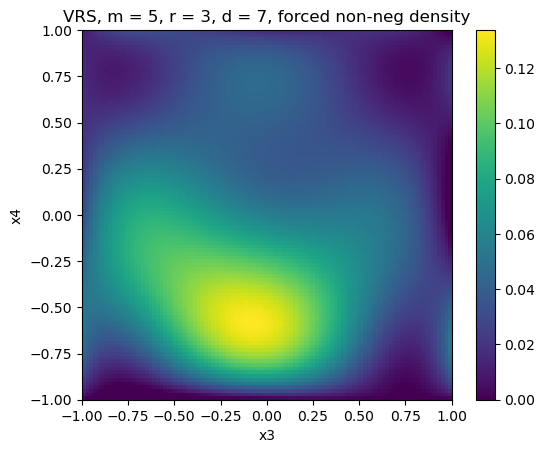

In [793]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 5, r = 3, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

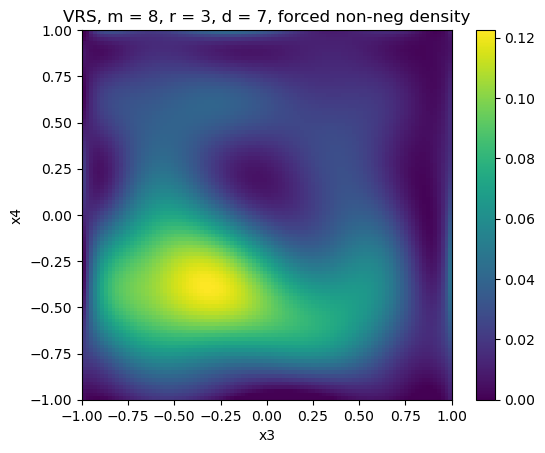

In [787]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 8, r = 3, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

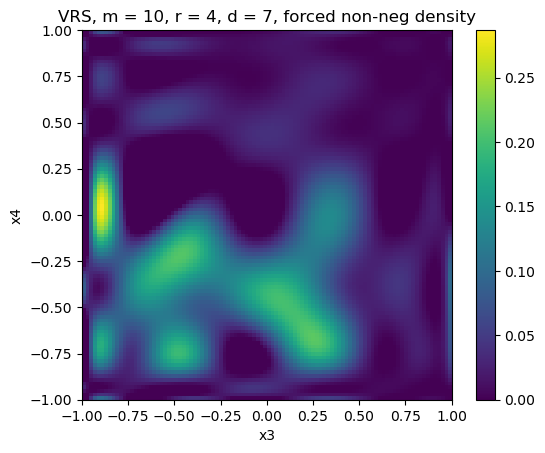

In [799]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 10, r = 4, d = 7, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

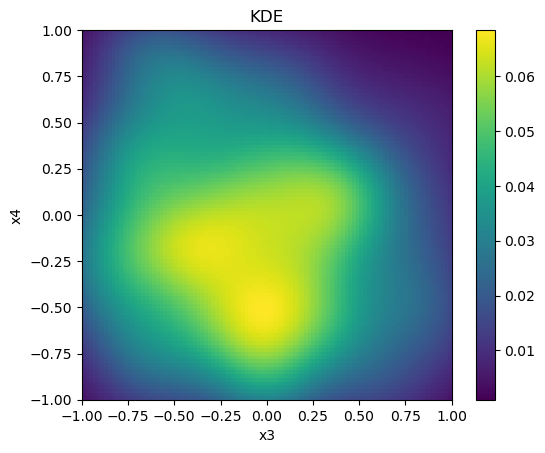

In [780]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

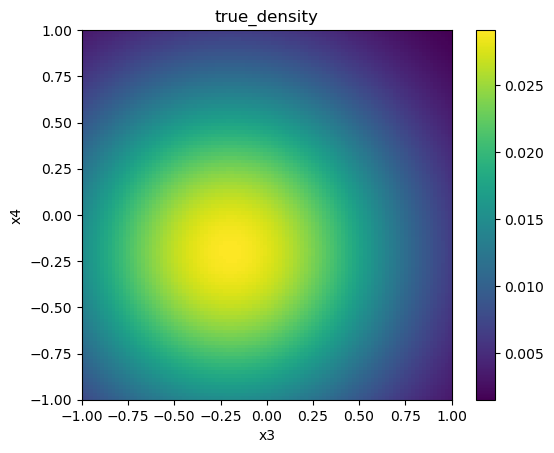

In [781]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true_density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [ ]:
# everything below has mean 0.5, standard deviation 0.1, N = 1000

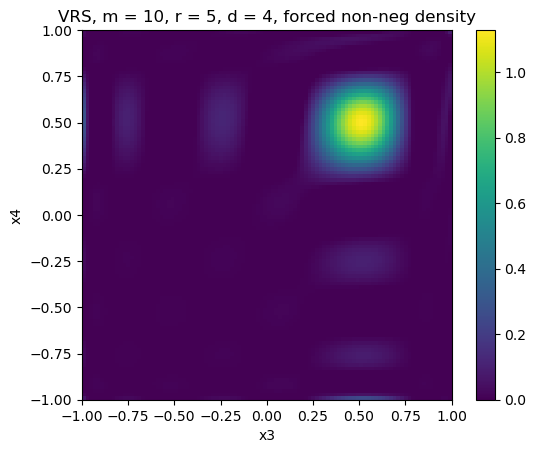

In [727]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 10, r = 5, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

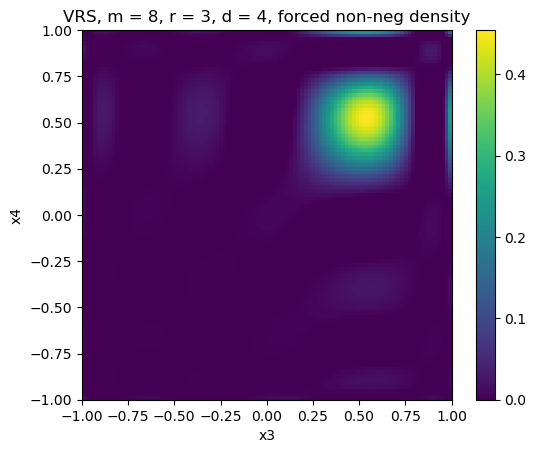

In [713]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 8, r = 3, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

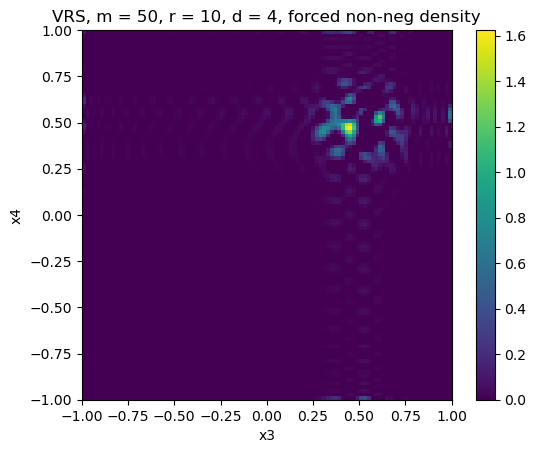

In [818]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 10, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

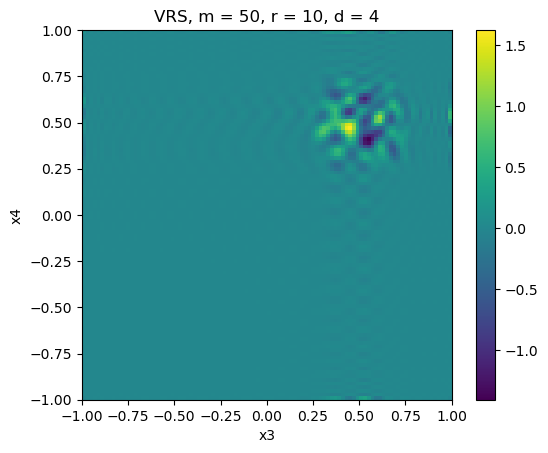

In [823]:
# above plot allowing for negative values
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 10, d = 4')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

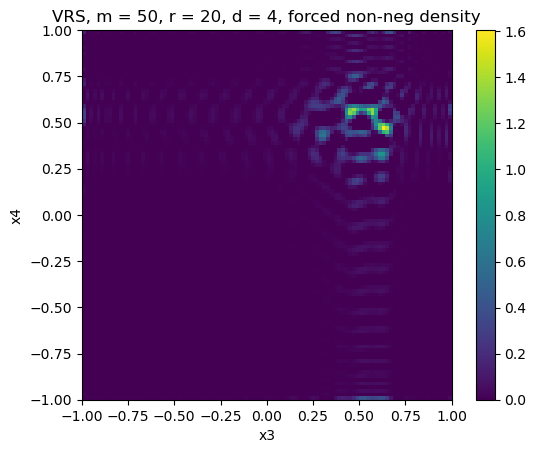

In [698]:
plt.imshow(density_vrs, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('VRS, m = 50, r = 20, d = 4, forced non-neg density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

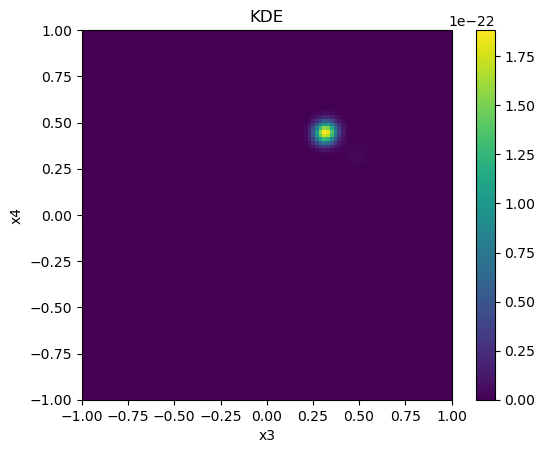

In [694]:
plt.imshow(density_kde, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('KDE')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

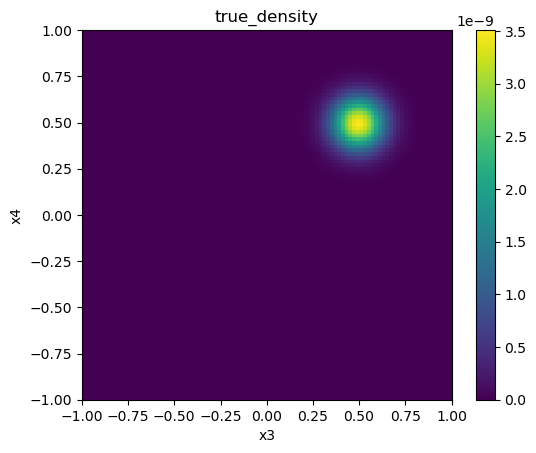

In [819]:
plt.imshow(true_density, extent=[-1, 1, -1, 1], origin='lower', cmap='viridis')
plt.title('true_density')
plt.xlabel('x3')
plt.ylabel('x4')
plt.colorbar()
plt.show()

In [649]:
# This bit below is trying to calculate the L2 error. I haven't really been able to get it working
# or maybe it does work and there is a bug else where
# either way just ignore everything below for now

pts = rng.normal(mean, std, size=(N, d))

f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])
f_kde = lambda pts: kde(pts.T)

In [650]:
def f_true(pts, mean, std):
    # unnormalized Gaussian
    vals = np.exp(-0.5 * np.sum(((pts - mean)/std)**2, axis=1))
    # compute normalization constant Z by Monte Carlo once
    MC = rng.uniform(-1,1,(200000, len(mean)))
    vals = np.exp(-0.5 * np.sum(((MC - mean)/std)**2, axis=1))
    const = np.mean(vals) * (2**len(mean))
    
    return vals / const

In [651]:
true = true_gaussian_density([0]*4,[0.3]*4)

In [652]:
M = 50000
pts_mc = rng.uniform(-1,1,(M, d))
domain_vol = 2**d


# compute relative L2 errors
err_vrs = relative_L2_error(f_vrs, true, pts_mc, domain_vol)
err_kde = relative_L2_error(f_kde, true, pts_mc, domain_vol)

## Checking relative L2 error, ignore for now, WIP

In [404]:
# Monte Carlo integrator for L2‐error
def relative_L2_error(f_est, f_true, sample_points, domain_vol):
    """
    f_est, f_true: callables taking array (M,d) → (M,)
    sample_points: array (M,d) drawn uniformly from domain
    domain_vol: volume of the domain
    """
    M = sample_points.shape[0]
    est_vals  = f_est(sample_points)
    true_vals = f_true(sample_points)
    sq_diff = (est_vals - true_vals)**2
    sq_true = true_vals**2
    # integral ≈ domain_vol * average
    int_diff = domain_vol * np.mean(sq_diff)
    int_true = domain_vol * np.mean(sq_true)
    return np.sqrt(int_diff / int_true)

In [554]:
def true_gaussian_density(mean, std):
    """Return a function f_true(pts) for pts (M,d)."""
    rng = default_rng()
    def f_true(pts):
        # unnormalized Gaussian
        vals = np.exp(-0.5 * np.sum(((pts - mean)/std)**2, axis=1))
        # compute normalization constant Z by Monte Carlo once
        return vals / const
    # estimate normalization constant Z = ∫_{[-1,1]^d} e^{-...} dx
    # via a quick MC
    MC = rng.uniform(-1,1,(200000, len(mean)))
    vals = np.exp(-0.5 * np.sum(((MC - mean)/std)**2, axis=1))
    const = np.mean(vals) * (2**len(mean))
    return f_true

In [452]:
results = []
for d in [2, 3, 4, 5, 6, 7]:
    N = 1000
    mean = np.zeros(d)
    std  = 0.3 * np.ones(d)
    # generate truncated Gaussian in d dims
    data = []
    rng = default_rng(123)
    while len(data) < N:
        pts = rng.normal(mean, std, size=(N, d))
        mask = np.all((pts >= -1) & (pts <= 1), axis=1)
        data.extend(pts[mask])
    data = np.array(data[:N])

    # Fit VRS
    r_list = [5]*d
    m_list = [8]*d
    C_e, basis = algorithm_3(data, r_list, m_list)

    # Build estimators
    f_vrs = lambda pts: np.array([eval_density(C_e, basis, z) for z in pts])
    kde   = gaussian_kde(data.T, bw_method='scott')
    f_kde = lambda pts: kde(pts.T)

    # Monte Carlo points for error
    M = 50000
    pts_mc = rng.uniform(-1,1,(M, d))
    domain_vol = 2**d

    # True density
    f_true = true_gaussian_density(mean, std)

    # compute relative L2 errors
    err_vrs = relative_L2_error(f_vrs, f_true, pts_mc, domain_vol)
    err_kde = relative_L2_error(f_kde, f_true, pts_mc, domain_vol)

    results.append((d, err_vrs, err_kde))
    print(d)
# ---- print results ----
print(f"{'d':>2}  {'VRS rel L2':>12}   {'KDE rel L2':>12}")
for d, e_vrs, e_kde in results:
    print(f"{d:2d}   {e_vrs: .4f}       {e_kde: .4f}")

2
3
4
5
6
7
 d    VRS rel L2     KDE rel L2
 2    0.1009        0.1195
 3    0.2050        0.1810
 4    0.3612        0.2591
 5    0.6306        0.3227
 6    1.0034        0.4392
 7    1.6097        0.4875


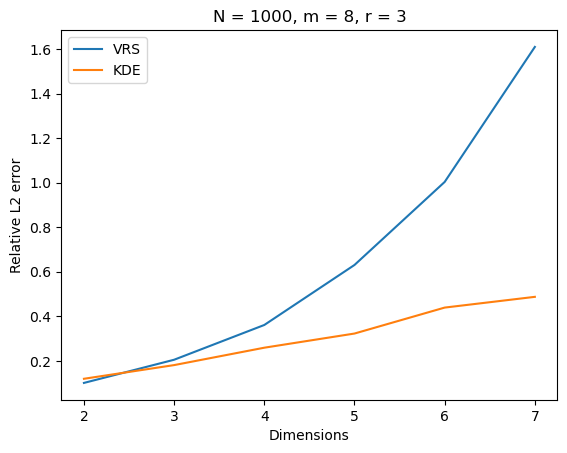

In [453]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title('N = 1000, m = 8, r = 5')
plt.legend();

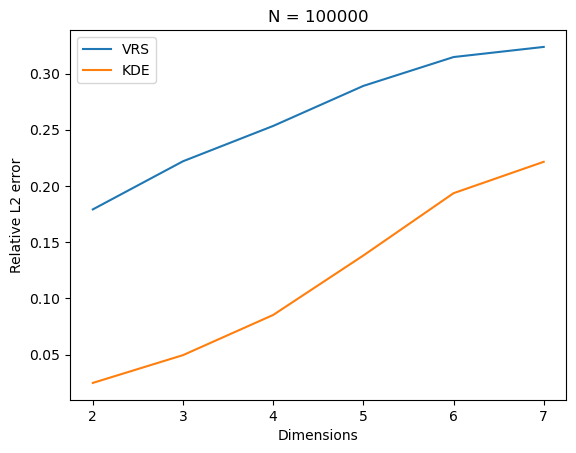

In [448]:
# m = 5, r = 3

plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.xlabel('Dimensions')
plt.ylabel('Relative L2 error')
plt.title('N = 100000')
plt.legend();

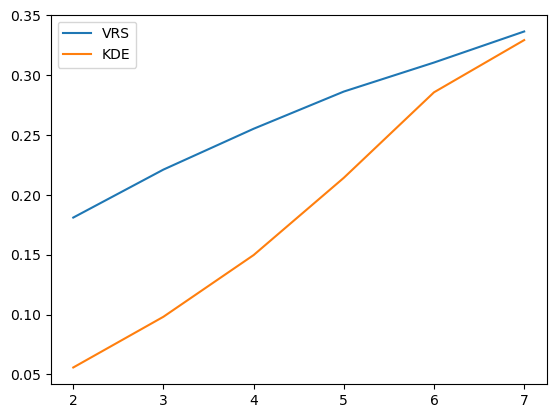

In [433]:
plt.plot(np.array(results)[:,0], np.array(results)[:,1], label = 'VRS')
plt.plot(np.array(results)[:,0], np.array(results)[:,2], label = 'KDE')
plt.legend();
# plot below is N=10000